**This part of the project includes:**

1. Fitting an initial regression model, conducting statistical analyses of the results, taking a look at the p-values of the various features and perform some feature selection. 
2. Testing for regression assumptions including normality, heteroscedasticity, and independence. 
3. From these tests, we'll then refine and improve the model, not just for performance, but for interpretability as well.
4. Improving and deepening our answers to business problems using built models.

**MODEL FITTING & VALIDATION**
**a.	Model Building Summary Steps:**

i.	Perform Stepwise Selection to select for features with p-value < 0.05

ii.	Build the model using statsmodels with the result from stepwise selection and get r2, adjusted r2

iii.	Predict yhat

1.	Plot yhat regplot

iv.	Test initial model

1.	Recheck multicollinearity with heatmap

2.	Recheck residuals normality with qqplot

3.	Recheck residuals homoscedasticity with regplot

v.	Validate initial model

1.	Train test split and fit the line

2.	Calculate MSE: very small difference = not overfitted

3.	Plot model residuals vs prediction with regplot

4.	Calculate accuracy percentage

vi.	Additional assessment:

1.	K-fold cross-validation

2.	Bias-variance tradeoff

**b.	Models:**

i.	Model A: All features + location

ii.	Model B: All features with outliers (3 STD away) removed + location

iii.Model C: Polynomial Regression on Model A

iv.	Model D: Log transformed all continuous features (not including target ‘price) + all features 

In [295]:
#import all necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
sns.set(style="whitegrid")

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

import scipy.stats as stats

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import pickle

import warnings
warnings.filterwarnings("ignore")

Recall that there are four main assumptions underlying a linear regression model:

1. **Linearity:** With linear models, the target variable is being modeled as a linear combination of the independent variables. As such, there should be a linear relationship between the target variable and the various features being used. 

2. **Normality:** With linear models, the errors (residuals) from the model are assumed to be normally distributed. A good heuristic to initially check for this is to use a Q-Q plot.

3. **Homoscedasticity:** Along with the assumption of normal distribution, error terms should also not be correlated with the target variable or other features within the model. If errors indeed appear to be random and there are no discernible trends, then the errors are said to be homoscedastic. Looking at a simple plot of residuals against the target variable or other feature is generally sufficient to gauge this.

4. **Independence:** Finally, regression models assume that the various independent features feeding into the model are independent. We will investigate multicollinearity. Multicollinearity is when a variable can be predicted with substantial accuracy by a separate set of features. It's unwise to include two features in a regression model that are highly correlated. This mistake will severely impede interpretation as coefficient weights of the model become unstable so it is difficult or impossible to determine which features are most influential.

In [296]:
#read our dataframe
clean = pd.read_csv('./Data & Figures/clean.csv', index_col = 0)
clean.head()

,price,price_log,sqft_above,sqft_above_log,sqft_lot,sqft_lot_log,sqft_living15,sqft_living15_log,sqft_lot15,age,...,cond_5.0,zip_A,zip_B,zip_C,zip_D,zip_E,zip_F,zip_G,zip_H,zip_I
15937,268950.0,12.502281,880,6.779922,8100,8.999619,1000,6.907755,8100,72,...,0,0,0,0,0,1,0,0,0,0
20963,399900.0,12.898970,900,6.802395,1005,6.912743,1440,7.272398,1188,4,...,0,0,0,0,0,0,0,1,0,0
7614,339000.0,12.733755,720,6.579251,4128,8.325548,1510,7.319865,4538,73,...,0,1,0,0,0,0,0,0,0,0
3257,380000.0,12.847927,840,6.733402,7372,8.905444,1930,7.565275,5150,76,...,1,1,0,0,0,0,0,0,0,0
16723,365000.0,12.807653,1600,7.377759,4168,8.335192,1190,7.081709,4168,88,...,0,1,0,0,0,0,0,0,0,0


In [297]:
clean.columns

Index(['price', 'price_log', 'sqft_above', 'sqft_above_log', 'sqft_lot',
       'sqft_lot_log', 'sqft_living15', 'sqft_living15_log', 'sqft_lot15',
       'age', 'bedrooms', 'bathrooms', 'floors', 'water_1.0', 'base_1.0',
       'reno_1.0', 'cond_2.0', 'cond_3.0', 'cond_4.0', 'cond_5.0', 'zip_A',
       'zip_B', 'zip_C', 'zip_D', 'zip_E', 'zip_F', 'zip_G', 'zip_H', 'zip_I'],
      dtype='object')

### Prepare Continuous Data: Feature Scaling

In [298]:
clean_continuous = clean[['price', 'sqft_above', 'sqft_lot', 'sqft_living15', 'sqft_lot15', 'age']]

In [299]:
# normalize (subract mean and divide by std)
def normalize(feature):
    return (feature - feature.mean()) / feature.std()

clean_continuous_norm = clean_continuous.apply(normalize)

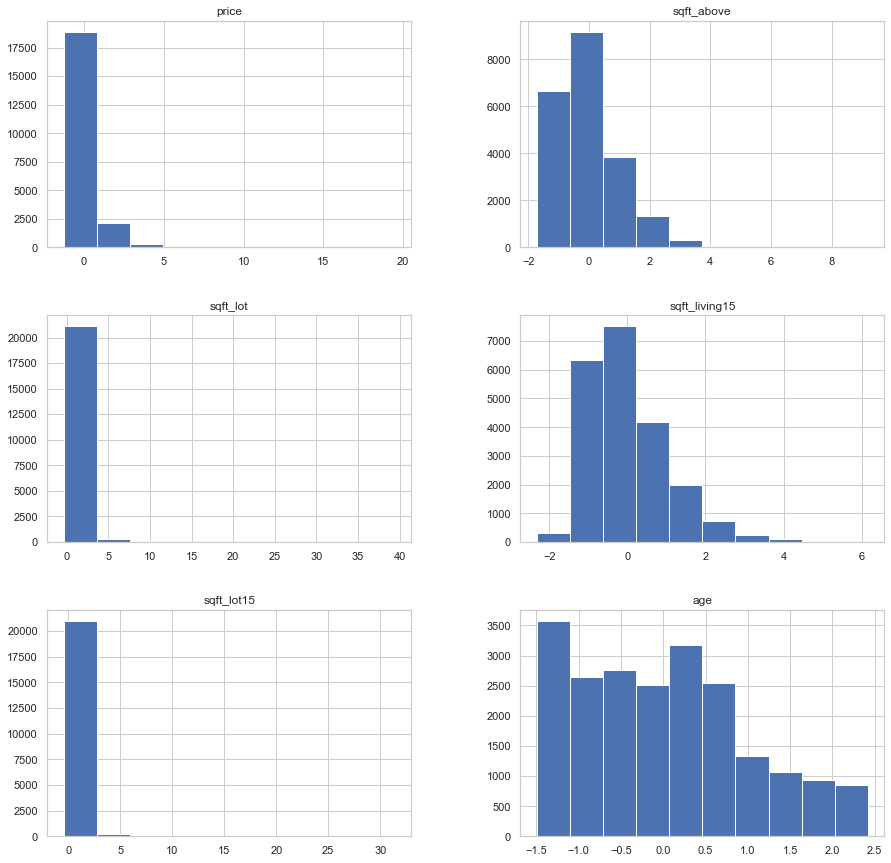

In [300]:
#plot the new normalized data
clean_continuous_norm.hist(figsize = (15, 15));

#save
plt.savefig('./Data & Figures/log_norm_histplot')

In [301]:
#drop old values
clean.drop(['price', 'sqft_above', 'sqft_lot', 'sqft_living15', 'sqft_lot15', 'age'], axis = 1, inplace = True)

In [302]:
#merge the newly normalized values
clean = pd.concat([clean, clean_continuous_norm], axis = 1) 

In [303]:
#review
clean.head()

,price_log,sqft_above_log,sqft_lot_log,sqft_living15_log,bedrooms,bathrooms,floors,water_1.0,base_1.0,reno_1.0,...,zip_F,zip_G,zip_H,zip_I,price,sqft_above,sqft_lot,sqft_living15,sqft_lot15,age
15937,12.502281,6.779922,8.999619,6.907755,3,1.00,1.0,0,1,0,...,0,0,0,0,-0.740571,-1.099527,-0.169225,-1.441766,-0.170986,0.955962
20963,12.898970,6.802395,6.912743,7.272398,2,1.75,1.5,0,1,0,...,0,1,0,0,-0.384457,-1.075393,-0.340062,-0.799934,-0.423750,-1.357975
7614,12.733755,6.579251,8.325548,7.319865,3,1.00,1.0,0,1,0,...,0,0,0,0,-0.550073,-1.292602,-0.264865,-0.697824,-0.301244,0.989991
3257,12.847927,6.733402,8.905444,7.565275,2,1.00,1.0,0,1,0,...,0,0,0,0,-0.438575,-1.147796,-0.186754,-0.085165,-0.278864,1.092076
16723,12.807653,7.377759,8.335192,7.081709,5,2.00,1.5,0,0,0,...,0,0,0,0,-0.479367,-0.230689,-0.263901,-1.164611,-0.314775,1.500418


# MODEL A: 
## USING STEPWISE SELECTION
## WITH ALL FEATURES (p_value < 0.05) INCLUDED

In [304]:
clean.columns

Index(['price_log', 'sqft_above_log', 'sqft_lot_log', 'sqft_living15_log',
       'bedrooms', 'bathrooms', 'floors', 'water_1.0', 'base_1.0', 'reno_1.0',
       'cond_2.0', 'cond_3.0', 'cond_4.0', 'cond_5.0', 'zip_A', 'zip_B',
       'zip_C', 'zip_D', 'zip_E', 'zip_F', 'zip_G', 'zip_H', 'zip_I', 'price',
       'sqft_above', 'sqft_lot', 'sqft_living15', 'sqft_lot15', 'age'],
      dtype='object')

In [305]:
#including all non-log-transformed features
preprocessed_A = clean[['price', 'sqft_above', 'sqft_lot', 'sqft_living15', 'sqft_lot15',
                      'age', 'bedrooms', 'bathrooms', 'floors', 
                      'water_1.0', 'base_1.0', 'reno_1.0',
                      'cond_2.0', 'cond_3.0', 'cond_4.0', 'cond_5.0',
                      'zip_A', 'zip_B', 'zip_C', 'zip_D', 'zip_E', 'zip_F', 'zip_G', 'zip_H', 'zip_I']]

In [306]:
#review
preprocessed_A.head(2)

,price,sqft_above,sqft_lot,sqft_living15,sqft_lot15,age,bedrooms,bathrooms,floors,water_1.0,...,cond_5.0,zip_A,zip_B,zip_C,zip_D,zip_E,zip_F,zip_G,zip_H,zip_I
15937,-0.740571,-1.099527,-0.169225,-1.441766,-0.170986,0.955962,3,1.00,1.0,0,...,0,0,0,0,0,1,0,0,0,0
20963,-0.384457,-1.075393,-0.340062,-0.799934,-0.423750,-1.357975,2,1.75,1.5,0,...,0,0,0,0,0,0,0,1,0,0


In [307]:
preprocessed_A.shape

(21420, 25)

In [308]:
preprocessed_A.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21420 entries, 15937 to 2495
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21420 non-null  float64
 1   sqft_above     21420 non-null  float64
 2   sqft_lot       21420 non-null  float64
 3   sqft_living15  21420 non-null  float64
 4   sqft_lot15     21420 non-null  float64
 5   age            21420 non-null  float64
 6   bedrooms       21420 non-null  int64  
 7   bathrooms      21420 non-null  float64
 8   floors         21420 non-null  float64
 9   water_1.0      21420 non-null  int64  
 10  base_1.0       21420 non-null  int64  
 11  reno_1.0       21420 non-null  int64  
 12  cond_2.0       21420 non-null  int64  
 13  cond_3.0       21420 non-null  int64  
 14  cond_4.0       21420 non-null  int64  
 15  cond_5.0       21420 non-null  int64  
 16  zip_A          21420 non-null  int64  
 17  zip_B          21420 non-null  int64  
 18  zip

In [309]:
#define X, y training set
X = preprocessed_A.drop(['price'], axis = 1)
y = preprocessed_A['price']

## Perform Stepwise Selection

In [310]:
#perform stepwise selection to ensure that we do not include any features with p-values of above 0.05 (learn.co)
def stepwise_selection(X, y, 
                       initial_list = [], 
                       threshold_in = 0.01, 
                       threshold_out = 0.05, 
                       verbose = True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed = False
        # forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [311]:
#apply function
result_A = stepwise_selection(X, y, verbose = True)
print('Resulting Features:')
print(result_A)

Add  sqft_above                     with p-value 0.0
Add  sqft_living15                  with p-value 0.0
Add  water_1.0                      with p-value 0.0
Add  age                            with p-value 0.0
Add  bathrooms                      with p-value 0.0
Add  zip_A                          with p-value 0.0
Add  zip_C                          with p-value 0.0
Add  base_1.0                       with p-value 8.75145e-194
Add  zip_B                          with p-value 6.9763e-191
Add  bedrooms                       with p-value 6.00824e-95
Add  zip_G                          with p-value 9.03639e-88
Add  zip_F                          with p-value 4.2296e-16
Add  cond_3.0                       with p-value 7.71182e-17
Add  reno_1.0                       with p-value 5.11113e-13
Add  zip_E                          with p-value 5.54062e-09
Add  zip_I                          with p-value 6.78986e-10
Add  cond_5.0                       with p-value 1.06607e-07
Add  floors        

In [312]:
#check out how many features satisfy p < 0.05
len(result_A)

19

## Build Model A

In [313]:
#build Model A in statsmodels
import statsmodels.api as sm

#interecept is not included by default and should be added manually
X_in = X[result_A]
X_intercept = sm.add_constant(X_in) 

#estimation by ordinary least squares (OLS)
model_A = sm.OLS(y, X_intercept).fit() 

#get summary
model_A.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     2269.
Date:                Fri, 29 Jan 2021   Prob (F-statistic):               0.00
Time:                        14:43:03   Log-Likelihood:                -18575.
No. Observations:               21420   AIC:                         3.719e+04
Df Residuals:                   21400   BIC:                         3.735e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.7156      0.049    -14.539      0.000      -0.812      -0.619
sqft_above        0.5371      0.008     66.059      0.000       0.521       0.553
sqft_living15     0.1774      0.006     27.777      0.000       0.165       0.190
water_1.0         2.3157      0.049     47.598      0.000       2.220       2.411
age               0.1435      0.006     23.171      0.000       0.131       0.156
bathrooms         0.2142      0.009     23.153      0.000       0.196       0.232
zip_A             0.7339      0.014     52.183      0.000       0.706       0.761
zip_C             0.7859      0.016     49.607      0.000       0.755       0.817
base_1.0          0.3287      0.011     31.006      0.000       0.308       0.350
zip_B             0.4750      0.015     31.426      0.000       0.445       0.505
bedrooms         -0.1109      0.006    -20.016      0.000      -0.122      -0.100
zip_G             0.3449      0.017     19.799      0.000       0.311       0.379
zip_F            -0.0820      0.018     -4.681      0.000      -0.116      -0.048
cond_3.0          0.0881      0.043      2.072      0.038       0.005       0.171
reno_1.0          0.1796      0.023      7.858      0.000       0.135       0.224
zip_E             0.1397      0.019      7.297      0.000       0.102       0.177
zip_I             0.1628      0.026      6.293      0.000       0.112       0.214
cond_5.0          0.2497      0.044      5.632      0.000       0.163       0.337
floors           -0.0567      0.011     -5.370      0.000      -0.077      -0.036
cond_4.0          0.1677      0.043      3.931      0.000       0.084       0.251
==============================================================================
Omnibus:                    17979.101   Durbin-Watson:                   1.284
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1611084.563
Skew:                           3.531   Prob(JB):                         0.00
Kurtosis:                      44.896   Cond. No.                         99.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* p-value of 0 which rejects the null hypothesis.
* Additionally, the kurtosis is > 3, indicating heavier tails than a normal distribution. 
* The skewness value of 3.5 shows that underlying data is not symmetrical. 

**Recheck for multicollinearity**

In [314]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 

#recheck for multicollinearity
X = preprocessed_A[result_A]
vif = [variance_inflation_factor(X[result_A].values, i) for i in range(X[result_A].shape[1])] 
list(zip(result_A, vif))

[('sqft_above', 3.904348154454156),
 ('sqft_living15', 2.631791723654887),
 ('water_1.0', 1.040567780803903),
 ('age', 2.3839636881714776),
 ('bathrooms', 27.03873230143135),
 ('zip_A', 4.354954006964036),
 ('zip_C', 1.9217549819048745),
 ('base_1.0', 2.8216111395652783),
 ('zip_B', 1.9350942349304505),
 ('bedrooms', 22.30466285895622),
 ('zip_G', 1.6475655450344544),
 ('zip_F', 1.517857999950974),
 ('cond_3.0', 23.10854748754023),
 ('reno_1.0', 1.1617169205536755),
 ('zip_E', 1.484989309950368),
 ('zip_I', 1.1993869515485946),
 ('cond_5.0', 3.89961354668642),
 ('floors', 17.115709258109163),
 ('cond_4.0', 9.72686534587317)]

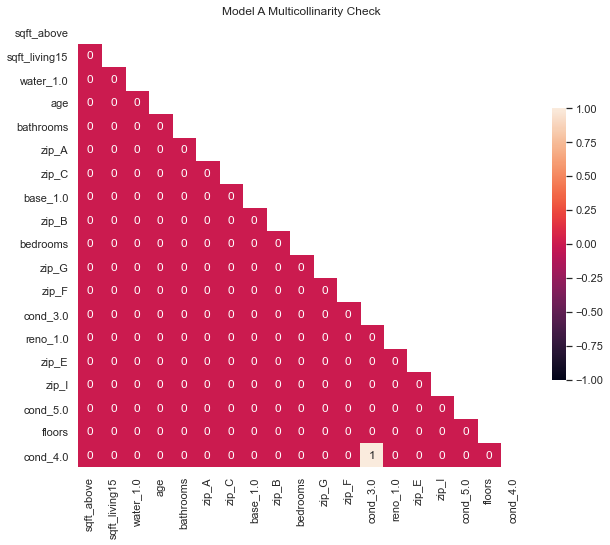

In [315]:
#recheck for multicollinearity
mask = np.zeros_like(abs(X[result_A].corr()) > 0.75)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax = sns.heatmap(abs(X[result_A].corr()) > 0.75, 
                     annot = True, 
                     ax = ax, 
                     cbar_kws = {"shrink": .5}, 
                     mask = mask, 
                     vmax = 1,
                     vmin = -1,
                     square = True)
    plt.title('Model A Multicollinarity Check')
plt.savefig('./Data & Figures/model_A_multicollinarity_check')

In [316]:
#drop 'cond_4.0' to avoid multicollinearity
preprocessed_A.drop('cond_4.0', axis = 1, inplace = True)

In [317]:
#redefine X, y training set
X = preprocessed_A.drop(['price'], axis = 1)
y = preprocessed_A['price']

In [318]:
#redo stepwise selection
result_A = stepwise_selection(X, y, verbose = True)
print('Resulting Features:')
print(result_A)

Add  sqft_above                     with p-value 0.0
Add  sqft_living15                  with p-value 0.0
Add  water_1.0                      with p-value 0.0
Add  age                            with p-value 0.0
Add  bathrooms                      with p-value 0.0
Add  zip_A                          with p-value 0.0
Add  zip_C                          with p-value 0.0
Add  base_1.0                       with p-value 8.75145e-194
Add  zip_B                          with p-value 6.9763e-191
Add  bedrooms                       with p-value 6.00824e-95
Add  zip_G                          with p-value 9.03639e-88
Add  zip_F                          with p-value 4.2296e-16
Add  cond_3.0                       with p-value 7.71182e-17
Add  reno_1.0                       with p-value 5.11113e-13
Add  zip_E                          with p-value 5.54062e-09
Add  zip_I                          with p-value 6.78986e-10
Add  cond_5.0                       with p-value 1.06607e-07
Add  floors        

In [319]:
#rebuild Model A
import statsmodels.api as sm

#interecept is not included by default and should be added manually
X_in = X[result_A]
X_intercept = sm.add_constant(X_in) 

#estimation by ordinary least squares (OLS)
model_A = sm.OLS(y, X_intercept).fit() 

#get summary
model_A.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     2268.
Date:                Fri, 29 Jan 2021   Prob (F-statistic):               0.00
Time:                        14:43:07   Log-Likelihood:                -18578.
No. Observations:               21420   AIC:                         3.720e+04
Df Residuals:                   21400   BIC:                         3.736e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.5501      0.028    -19.884      0.000      -0.604      -0.496
sqft_above        0.5373      0.008     66.073      0.000       0.521       0.553
sqft_living15     0.1772      0.006     27.739      0.000       0.165       0.190
water_1.0         2.3150      0.049     47.575      0.000       2.220       2.410
age               0.1431      0.006     23.120      0.000       0.131       0.155
bathrooms         0.2142      0.009     23.157      0.000       0.196       0.232
zip_A             0.7337      0.014     52.164      0.000       0.706       0.761
zip_C             0.7859      0.016     49.600      0.000       0.755       0.817
base_1.0          0.3292      0.011     31.052      0.000       0.308       0.350
zip_B             0.4748      0.015     31.407      0.000       0.445       0.504
bedrooms         -0.1107      0.006    -19.977      0.000      -0.122      -0.100
zip_G             0.3447      0.017     19.784      0.000       0.311       0.379
zip_F            -0.0821      0.018     -4.685      0.000      -0.116      -0.048
cond_3.0         -0.0780      0.010     -7.753      0.000      -0.098      -0.058
reno_1.0          0.1798      0.023      7.865      0.000       0.135       0.225
zip_E             0.1390      0.019      7.259      0.000       0.101       0.176
zip_I             0.1622      0.026      6.268      0.000       0.111       0.213
cond_5.0          0.0838      0.016      5.160      0.000       0.052       0.116
floors           -0.0569      0.011     -5.387      0.000      -0.078      -0.036
cond_2.0         -0.1352      0.046     -2.937      0.003      -0.225      -0.045
==============================================================================
Omnibus:                    17964.927   Durbin-Watson:                   1.284
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1607735.037
Skew:                           3.527   Prob(JB):                         0.00
Kurtosis:                      44.853   Cond. No.                         56.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [320]:
#create linear regression object
linreg = LinearRegression()

#fit model
linreg.fit(X[result_A], y)

#predict yhat using our model
yhat = linreg.predict(X[result_A])
yhat

array([-1.04396899, -0.79988517, -0.33824057, ..., -0.71789283,
       -0.34289998, -0.52898149])

In [321]:
#get intercept
linreg.intercept_

-0.5501355394147036

In [322]:
#get coefficients and sort them
coefficients = dict(zip(X[result_A], list(linreg.coef_)))
dict(sorted(coefficients.items(), key = lambda item: item[1]))

{'cond_2.0': -0.1352321102557107,
 'bedrooms': -0.11066913362648398,
 'zip_F': -0.08210151123051032,
 'cond_3.0': -0.07800378763802455,
 'floors': -0.05685379780858842,
 'cond_5.0': 0.08376544156920117,
 'zip_E': 0.13896434716421574,
 'age': 0.1431437039240749,
 'zip_I': 0.1622067074399153,
 'sqft_living15': 0.17720665726244655,
 'reno_1.0': 0.17982888317665505,
 'bathrooms': 0.21423240143100758,
 'base_1.0': 0.3292482733084555,
 'zip_G': 0.3446530600607671,
 'zip_B': 0.4748351089055141,
 'sqft_above': 0.5372882770934384,
 'zip_A': 0.733723493705701,
 'zip_C': 0.7858900555592185,
 'water_1.0': 2.3149770267772407}

**Features that decreases value of the home:**

* 'cond_2.0': -0.13523211025571083,
* 'bedrooms': -0.110669133626482,
* 'zip_F': -0.08210151123051071,
* 'cond_3.0': -0.0780037876380249,
* 'floors': -0.05685379780858867,

**Features that increases value of the home:**
* 'cond_5.0': 0.08376544156919936,
* 'zip_E': 0.1389643471642145,
* 'age': 0.1431437039240746,
* 'zip_I': 0.16220670743991517,
* 'sqft_living15': 0.17720665726244836,
* 'reno_1.0': 0.1798288831766561,
* 'bathrooms': 0.21423240143100827,
* 'base_1.0': 0.32924827330845347,
* 'zip_G': 0.3446530600607671,
* 'zip_B': 0.47483510890551495,
* 'sqft_above': 0.5372882770934376,
* 'zip_A': 0.7337234937057004,
* 'zip_C': 0.7858900555592188,
* 'water_1.0': 2.3149770267772363

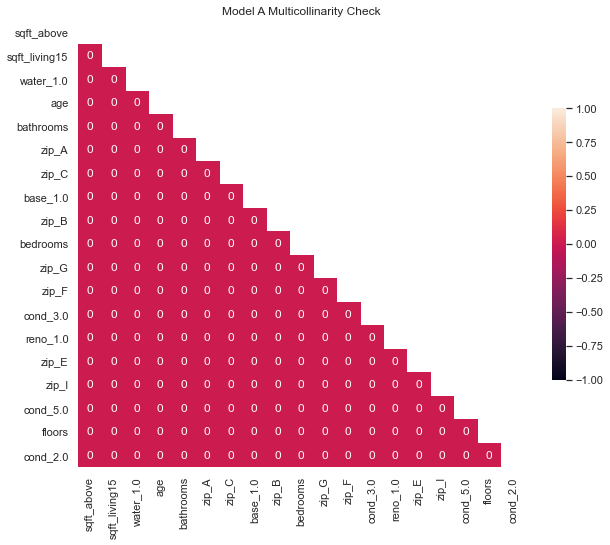

In [323]:
#recheck for multicollinearity
mask = np.zeros_like(abs(X[result_A].corr()) > 0.75)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax = sns.heatmap(abs(X[result_A].corr()) > 0.75, 
                     annot = True, 
                     ax = ax, 
                     cbar_kws = {"shrink": .5}, 
                     mask = mask, 
                     vmax = 1,
                     vmin = -1,
                     square = True)
    plt.title('Model A Multicollinarity Check')
plt.savefig('./Data & Figures/model_A_multicollinarity_check')

**Recheck for normality**

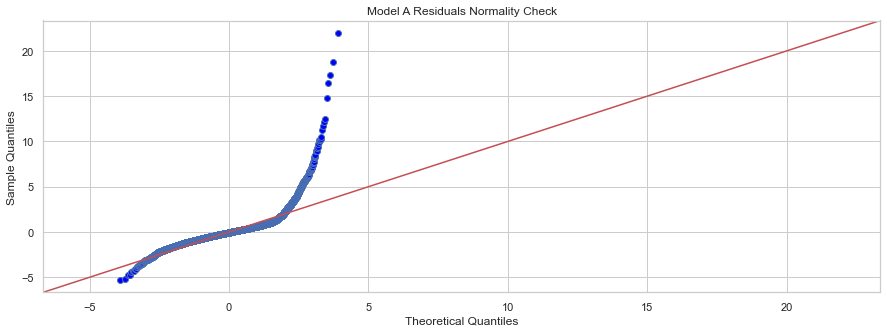

<Figure size 432x288 with 0 Axes>

In [324]:
#recheck for normality
fig = sm.graphics.qqplot(model_A.resid, 
                         dist = stats.norm, 
                         line = '45', 
                         fit = True)
fig.set_size_inches(15, 5)
plt.title('Model A Residuals Normality Check')
plt.show()
plt.savefig('./Data & Figures/model_A_residuals_qqplot')

**Recheck for homoscedasticity**

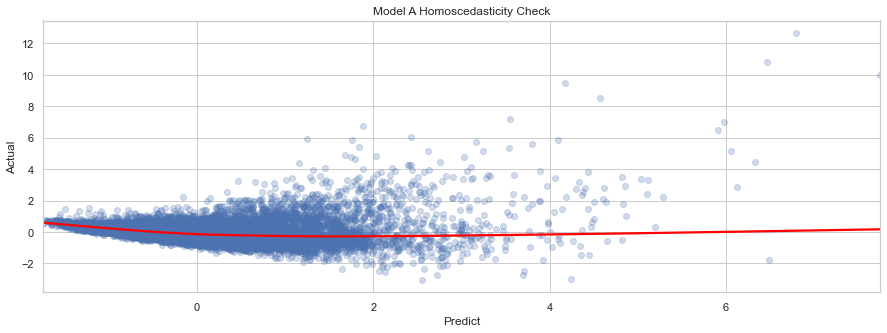

<Figure size 432x288 with 0 Axes>

In [325]:
#recheck for homoscedasticity
plt.figure(figsize = (15, 5))
sns.regplot(x = model_A.predict(), 
            y = model_A.resid, 
            lowess = True, 
            line_kws = {'color': 'red'},
            scatter_kws = {'color':'b','alpha':0.25})
plt.title('Model A Homoscedasticity Check')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()
plt.savefig('./Data & Figures/model_A_homoscedasticity_regplot')

In [326]:
#Goldfeld-Quandt test
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(model_A.resid, model_A.model.exog)
list(zip(name, test))

[('F statistic', 1.0157928175913467), ('p-value', 0.20896254809615292)]

**Recheck for overfitting: K-Fold Cross Validation**

In [327]:
#cross-validation to check for overfitting
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score

linreg = LinearRegression()

#get the mean squared error
mse = make_scorer(mean_squared_error)

cv_result = cross_val_score(linreg, X, y, cv = 10, scoring = 'neg_mean_squared_error')
cv_result

array([-0.44710665, -0.2198019 , -0.29026356, -0.41013214, -0.31306042,
       -0.32327282, -0.30570116, -0.34842427, -0.39989588, -0.31003089])

In [328]:
#the accuracy of the model is the average of the accuracy of each fold
cv_result.mean()

-0.33676896902113007

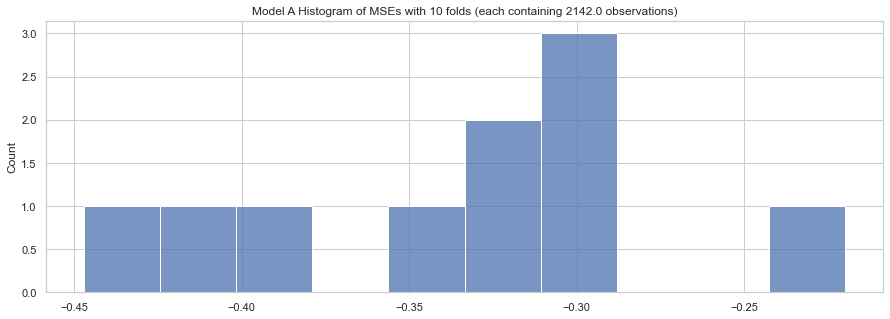

In [329]:
#visualize the cv_result
folds = 10
plt.figure(figsize = (15, 5))
sns.histplot(cv_result, bins = 10);
plt.title('Model A Histogram of MSEs with {} folds (each containing {} observations)'
          .format(folds, round(len(preprocessed_A) / folds, 0)));
plt.savefig('./Data & Figures/model_A_cv_result_histplot')

Our regression visualization suggests that there are some splits for which our fitted model performs significantly less well.

## Validate Model A

In [330]:
#split the data into training and test sets. Use the default split size
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X[result_A], y, test_size = 0.2, random_state = 42)
print(len(X_train), len(y_train), len(X_test), len(y_test))

17136 17136 4284 4284


In [331]:
#import and initialize the linear regression model class
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()

#fit the model to train data
linreg.fit(X_train, y_train)

#calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

To evaluate the model, we compare our predicted values, yhat with the actual value 𝑦 . The difference between the two values is referred to as the residuals. We'll compare our residuals for both test set and training set. To get a summarized measure over all the instances in the test set and training set, a popular metric is the RME (Root Mean Squared Error). A big difference in value between the test and training set (R)MSE is an indication of overfitting.

In [332]:
#calculate residuals (prediction - actual error)
train_residual = y_hat_train - y_train
test_residual = y_hat_test - y_test

In [333]:
#calculate training and test MSE
from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)

print(train_mse)
print(test_mse)

0.31643616554066867
0.39522764027537394


Our (R)MSE of train set and test set are quite similar, we  did not overfit the model.

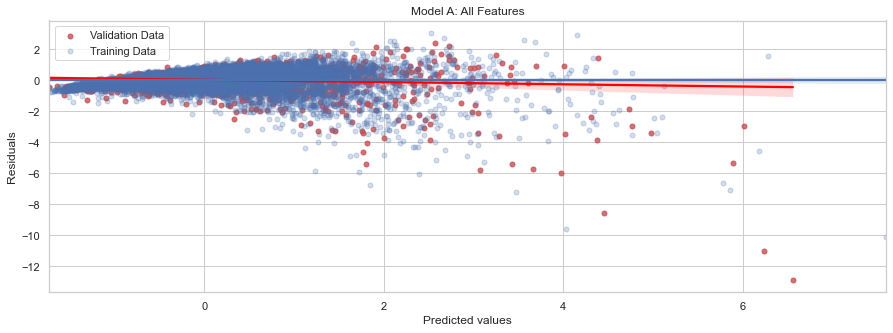

<Figure size 432x288 with 0 Axes>

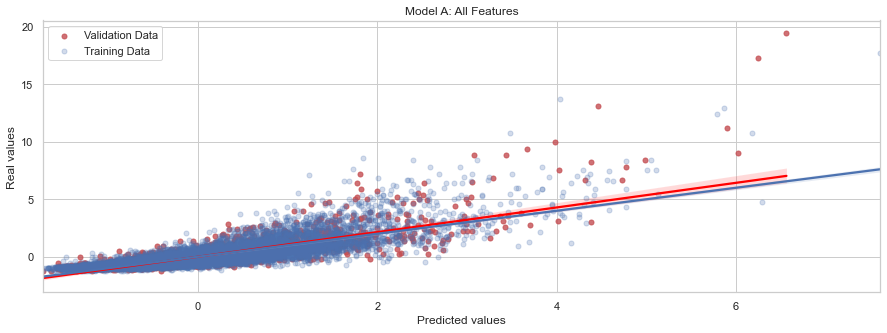

<Figure size 432x288 with 0 Axes>

In [334]:
#plot residuals: 
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_hat_test - y_test,
            scatter_kws = {'s': 25}, 
            line_kws = {'color': 'red'},
            color = 'r',
            fit_reg = True, label = 'Validation Data')
sns.regplot(x = y_hat_train, y = y_hat_train - y_train,
            scatter_kws = {'s': 25,'alpha':0.25}, fit_reg = True, label = 'Training Data')


plt.title('Model A: All Features')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig('./Data & Figures/model_A_residuals_regplot')

#plot predictions
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_test,
            scatter_kws = {'s': 25}, 
            line_kws = {'color': 'red'},
            color = 'r',
            fit_reg = True, label = 'Validation Data')
sns.regplot(x = y_hat_train, y = y_train,
            scatter_kws = {'s': 25,'alpha':0.25}, 
            fit_reg = True, label = 'Training Data')

plt.title('Model A: All Features')
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig('./Data & Figures/model_A_predictions_regplot')

In [335]:
#get accuracy percentage
accuracy = linreg.score(X_test, y_test)
'Accuracy: {}%'.format(int(round(accuracy * 100)))

'Accuracy: 66%'

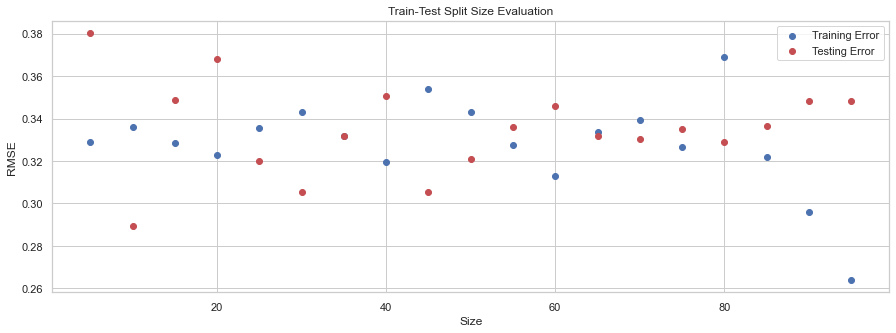

In [336]:
#evaluating the effect of train-test split size
import random
random.seed(11)

train_err = []
test_err = []
t_sizes = list(range(5, 100, 5))

for t_size in t_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = t_size / 100)
    linreg.fit(X_train, y_train)
    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)
    train_err.append(mean_squared_error(y_train, y_hat_train))
    test_err.append(mean_squared_error(y_test, y_hat_test))
    
plt.figure(figsize = (15, 5))    
plt.scatter(t_sizes, train_err, label = 'Training Error')
plt.scatter(t_sizes, test_err, label = 'Testing Error', color = 'r')
plt.title('Train-Test Split Size Evaluation')
plt.xlabel('Size')
plt.ylabel('RMSE')
plt.legend()
plt.savefig('./Data & Figures/model_A_traintestsplit_scatterplot')

### Bias-Variance Tradeoff

In [337]:
# Transform with MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Scale the train set
X_train_scaled = scaler.fit_transform(X_train)

# Scale the test set
X_test_scaled = scaler.transform(X_test)

In [338]:
# Training set predictions
lm_train_predictions = linreg.predict(X_train_scaled)

# Test set predictions 
lm_test_predictions = linreg.predict(X_test_scaled)

In [339]:
#function bias() to calculate the bias of a model's predictions given the actual data
def bias(y, y_hat):
    return np.mean(y_hat - y)

#function variance() to calculate the variance of a model's predictions
def variance(y_hat):
    return np.mean([yi**2 for yi in y_hat]) - np.mean(y_hat)**2

In [340]:
#bias and variance for training set 
b = bias(y_train, lm_train_predictions) 
v = variance(lm_train_predictions) 
print('Train bias: {} \nTrain variance: {}'.format(b, v))

Train bias: 0.22767412570202303 
Train variance: 0.19234102070456935


In [341]:
#bias and variance for test set 
b = bias(y_test, lm_test_predictions) 
v = variance(lm_test_predictions) 
print('Test bias: {} \nTest variance: {}'.format(b, v))

Test bias: 0.22630634251780918 
Test variance: 0.20141994854671008


In [342]:
import pickle

#save model
tuple_objects = (linreg, X_train, y_train)
pickle.dump(tuple_objects, open('./Data & Figures/model_A.pkl','wb'))

In [343]:
#summary table
summary_table_1 = pd.DataFrame({'Model': [], 'Description':[], ' Num Features' : [], 
                                'r2': [], 'Accuracy':[], 
                                'Multicollinearity': [], 'Normality': [], 'Homoscedasticity': [], 
                                'Cross Validation': []})
summary_table_1.loc[0] = ['Model A', 'All features', len(result_A), 
                          r2_score(y, yhat), accuracy * 100, 
                          'P', 'F', 'F', 
                          cv_result.mean()]
summary_table_1.head()

,Model,Description,Num Features,r2,Accuracy,Multicollinearity,Normality,Homoscedasticity,Cross Validation
0,Model A,All features,19.0,0.668177,66.236718,P,F,F,-0.336769


# MODEL B 
## REFINEMENT I: 
## REMOVE OUTLIERS THAT ARE 3 STD AWAY FROM THE MEAN

In [344]:
#review
preprocessed_A.columns

Index(['price', 'sqft_above', 'sqft_lot', 'sqft_living15', 'sqft_lot15', 'age',
       'bedrooms', 'bathrooms', 'floors', 'water_1.0', 'base_1.0', 'reno_1.0',
       'cond_2.0', 'cond_3.0', 'cond_5.0', 'zip_A', 'zip_B', 'zip_C', 'zip_D',
       'zip_E', 'zip_F', 'zip_G', 'zip_H', 'zip_I'],
      dtype='object')

In [345]:
#removie outliers in 'bedrooms'
count = 0
bedrooms_outliers = []
mean = np.mean(preprocessed_A['bedrooms'])
std = np.std(preprocessed_A['bedrooms'])
cut_off = np.std(preprocessed_A['bedrooms']) * 3 

for idx, row in preprocessed_A['bedrooms'].T.iteritems():
    if abs(row - mean) >= cut_off:
        count += 1
        preprocessed_A.drop(idx, inplace = True)
count

61

In [346]:
#removie outliers in 'bathrooms'
count = 0
bathrooms_outliers = []
mean = np.mean(preprocessed_A['bathrooms'])
std = np.std(preprocessed_A['bathrooms'])
cut_off = np.std(preprocessed_A['bathrooms']) * 3 

for idx, row in preprocessed_A['bathrooms'].T.iteritems():
    if abs(row - mean) >= cut_off:
        count += 1
        preprocessed_A.drop(idx, inplace = True)
count

171

In [347]:
#create new dataframe excluding outliers
preprocessed_B = preprocessed_A[['price', 'sqft_above', 'sqft_lot', 'sqft_living15', 'sqft_lot15', 
                                 'age', 'bedrooms', 'bathrooms', 'floors', 
                                 'water_1.0', 'base_1.0', 'reno_1.0',
                                 'cond_2.0', 'cond_3.0', 'cond_5.0', 
                                 'zip_A', 'zip_B', 'zip_C', 'zip_D', 'zip_E', 'zip_F', 'zip_G', 'zip_H', 'zip_I']]

In [348]:
X = preprocessed_B.drop(['price'], axis = 1)
y = preprocessed_B['price']

In [349]:
len(result_A)

19

In [350]:
#feature ranking with recursive feature elimination
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()

#set number of features to be 13 to be consistent with previous Model 1 of Stepwise Selection
selector = RFE(linreg, n_features_to_select = 13) 

#convert y to 1d np array to prevent DataConversionWarning
selector = selector.fit(X, y.values.ravel()) 
selector.support_

array([ True, False,  True, False, False, False, False, False,  True,
        True,  True, False, False,  True,  True, False,  True,  True,
        True,  True, False,  True,  True])

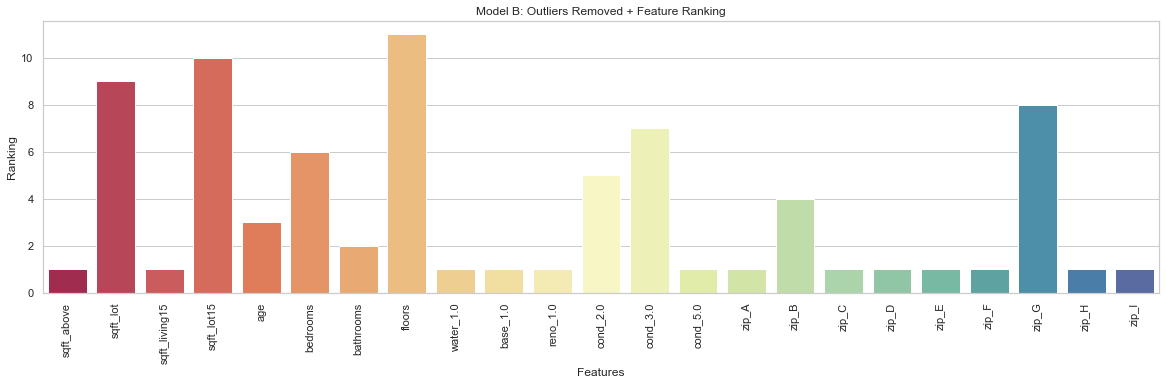

<Figure size 432x288 with 0 Axes>

In [351]:
#plot features ranking
plt.figure(figsize = (20, 5))
sns.barplot(x = X.columns, y = selector.ranking_, palette = 'Spectral');
plt.title('Model B: Outliers Removed + Feature Ranking')
plt.xlabel('Features')
plt.ylabel('Ranking')
plt.xticks(rotation = 90)
plt.show()
plt.savefig('./Data & Figures/recursive_features_elimination')

## Build Model B

In [352]:
#fit the linear regression model again using the selected columns
selected_features = X.columns[selector.support_ ]

linreg.fit(X[selected_features], y)

LinearRegression()

In [353]:
#build model B 
#interecept is not included by default and should be added manually
X_in = X[selected_features]
X_intercept = sm.add_constant(X_in) 

#estimation by ordinary least squares (OLS)
model_B = sm.OLS(y, X_intercept).fit() 

#get summary
model_B.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     2970.
Date:                Fri, 29 Jan 2021   Prob (F-statistic):               0.00
Time:                        14:43:27   Log-Likelihood:                -16753.
No. Observations:               21188   AIC:                         3.353e+04
Df Residuals:                   21174   BIC:                         3.365e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.2249      0.008    -26.495      0.000      -0.242      -0.208
sqft_above        0.4486      0.006     72.861      0.000       0.437       0.461
sqft_living15     0.2213      0.006     36.475      0.000       0.209       0.233
water_1.0         2.1133      0.047     44.828      0.000       2.021       2.206
base_1.0          0.3382      0.008     40.063      0.000       0.322       0.355
reno_1.0          0.3267      0.020     15.990      0.000       0.287       0.367
cond_5.0          0.2310      0.014     16.753      0.000       0.204       0.258
zip_A             0.3622      0.011     32.737      0.000       0.341       0.384
zip_C             0.3372      0.013     25.397      0.000       0.311       0.363
zip_D            -0.4192      0.016    -26.669      0.000      -0.450      -0.388
zip_E            -0.2549      0.017    -14.968      0.000      -0.288      -0.222
zip_F            -0.5209      0.015    -33.725      0.000      -0.551      -0.491
zip_H            -0.4713      0.016    -29.136      0.000      -0.503      -0.440
zip_I            -0.2671      0.023    -11.459      0.000      -0.313      -0.221
==============================================================================
Omnibus:                    13250.452   Durbin-Watson:                   1.159
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           328483.030
Skew:                           2.588   Prob(JB):                         0.00
Kurtosis:                      21.582   Cond. No.                         16.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [354]:
#create linear regression object
linreg = LinearRegression()

#fit model
linreg.fit(X[selected_features], y)

#predict yhat using our model
yhat = linreg.predict(X[selected_features])
yhat

array([-0.9538422 , -0.54606172, -0.25866633, ..., -0.57466738,
       -0.28911522, -0.39310103])

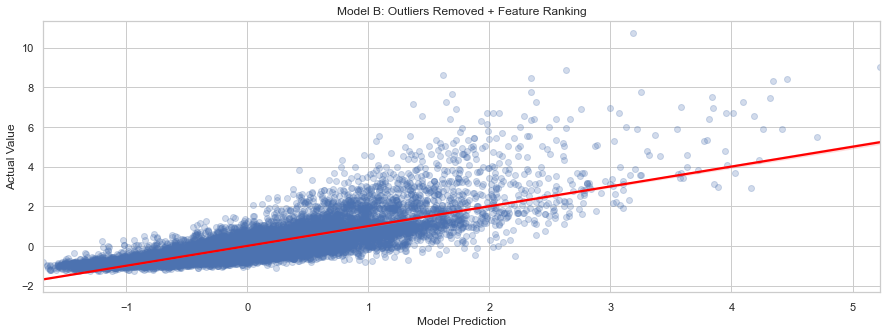

In [355]:
#plot y_hat
plt.figure(figsize = (15, 5))
sns.regplot(yhat, y, 
            line_kws = {'color': 'red'},
            scatter_kws = {'color':'b','alpha':0.25},color='r')
plt.title('Model B: Outliers Removed + Feature Ranking')
plt.xlabel('Model Prediction')
plt.ylabel('Actual Value');
plt.savefig('./Data & Figures/model_B_regplot')

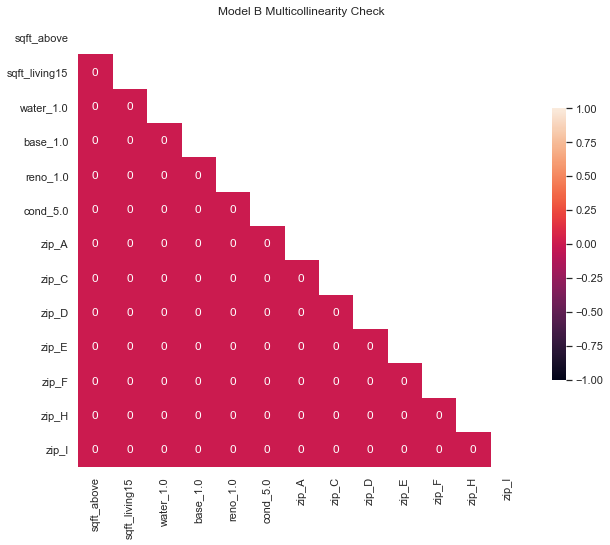

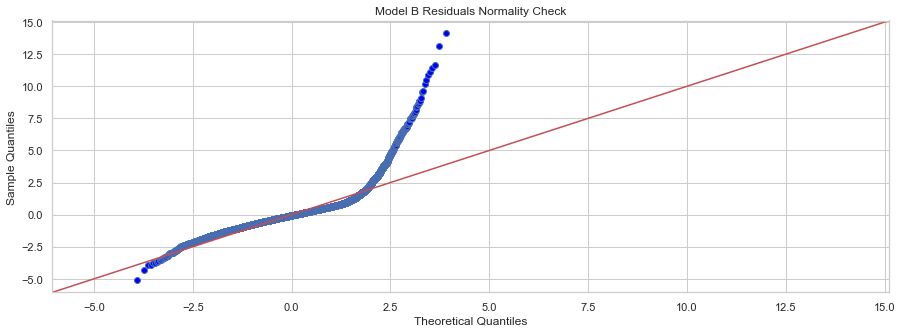

<Figure size 432x288 with 0 Axes>

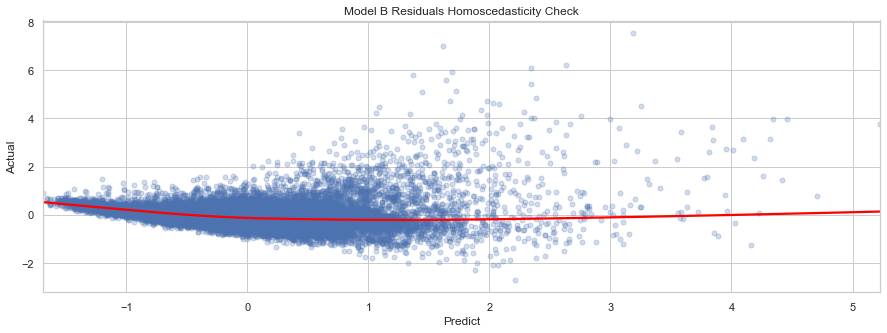

<Figure size 432x288 with 0 Axes>

In [356]:
#recheck for multicollinearity
mask = np.zeros_like(abs(X[selected_features].corr()) > 0.75)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax = sns.heatmap(abs(X[selected_features].corr()) > 0.75, 
                     annot = True, 
                     ax = ax, 
                     cbar_kws = {"shrink": .5}, 
                     mask = mask, 
                     vmax = 1,
                     vmin = -1,
                     square = True)
    plt.title('Model B Multicollinearity Check')
plt.savefig('./Data & Figures/model_B_multicollinarity_check')

#recheck for normality
fig = sm.graphics.qqplot(model_B.resid, 
                         dist = stats.norm, 
                         line = '45', 
                         fit = True)
fig.set_size_inches(15, 5)
plt.title('Model B Residuals Normality Check')
plt.show()
plt.savefig('./Data & Figures/model_B_residuals_qqplot')

#recheck for homoscedasticity
plt.figure(figsize = (15, 5))
sns.regplot(x = model_B.predict(), 
            y = model_B.resid, 
            lowess = True, 
            line_kws = {'color': 'red'},
            scatter_kws = {'s': 25,'alpha': 0.25})
plt.title('Model B Residuals Homoscedasticity Check')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()
plt.savefig('./Data & Figures/model_B_homoscedasticity_regplot')

Without log-transformation of data, we keep failing the normality and homoscedasticity assumptions. 

In [357]:
#split the data into training and test sets. Use the default split size
X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size = 0.2, random_state = 42)
print(len(X_train), len(y_train), len(X_test), len(y_test))

linreg = LinearRegression()

#fit the model to train data
linreg.fit(X_train, y_train)

#calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

#calculate residuals (prediction - actual error)
train_residual = y_hat_train - y_train
test_residual = y_hat_test - y_test

#calculate training and test MSE
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)

print(train_mse)
print(test_mse)

16950 16950 4238 4238
0.2845025512940657
0.2854815289776514


In [358]:
#get accuracy percentage
accuracy = linreg.score(X_test, y_test)
'Accuracy: {}%'.format(int(round(accuracy * 100)))

'Accuracy: 64%'

In [359]:
#cross-validation to check for overfitting
linreg = LinearRegression()

cv_result = cross_val_score(linreg, X[selected_features], y, cv = 10, scoring = 'neg_mean_squared_error')
print(cv_result.mean())

-0.2887121181852722


In [360]:
#save model
tuple_objects = (linreg, X_train, y_train)
pickle.dump(tuple_objects, open('./Data & Figures/model_B.pkl','wb'))

In [361]:
summary_table_1.loc[1] = ['Model B', 'All features, outliers removed, RFE', len(selected_features), 
                          r2_score(y, yhat), accuracy * 100,
                         'P', 'F', 'F', 
                          cv_result.mean()]
summary_table_1.head()

,Model,Description,Num Features,r2,Accuracy,Multicollinearity,Normality,Homoscedasticity,Cross Validation
0,Model A,All features,19.0,0.668177,66.236718,P,F,F,-0.336769
1,Model B,"All features, outliers removed, RFE",13.0,0.645805,64.221137,P,F,F,-0.288712


# MODEL C
## MODEL REFINEMENT II:
## POLYNOMIAL REGRESSION

Without log-transformation of data, we keep failing the normality and homoscedasticity assumptions. The troublesome features are 'price', 'sqft_above', 'sqft_lot', 'sqft_living15', and 'sqft_lot15'.

Model C will be a refinement of Model A, since Model B (with outliers removed) did not improve and we don't want to remove outliers without a convincing reason.

In [362]:
#create new dataframe
preprocessed_C = clean[['price', 'sqft_above', 'sqft_lot', 'sqft_living15', 'sqft_lot15',
                      'age', 'bedrooms', 'bathrooms', 'floors', 
                      'water_1.0', 'base_1.0', 'reno_1.0',
                      'cond_2.0', 'cond_3.0', 'cond_4.0', 'cond_5.0',
                      'zip_A', 'zip_B', 'zip_C', 'zip_D', 'zip_E', 'zip_F', 'zip_G', 'zip_H', 'zip_I']]

preprocessed_C.head(2)

,price,sqft_above,sqft_lot,sqft_living15,sqft_lot15,age,bedrooms,bathrooms,floors,water_1.0,...,cond_5.0,zip_A,zip_B,zip_C,zip_D,zip_E,zip_F,zip_G,zip_H,zip_I
15937,-0.740571,-1.099527,-0.169225,-1.441766,-0.170986,0.955962,3,1.00,1.0,0,...,0,0,0,0,0,1,0,0,0,0
20963,-0.384457,-1.075393,-0.340062,-0.799934,-0.423750,-1.357975,2,1.75,1.5,0,...,0,0,0,0,0,0,0,1,0,0


In [363]:
#transform non-normal features
preprocessed_C['sqft_above_poly'] = preprocessed_C['sqft_above']**2
preprocessed_C['sqft_lot_poly'] = preprocessed_C['sqft_lot']**2
preprocessed_C['sqft_living15_poly'] = preprocessed_C['sqft_living15']**2
preprocessed_C['sqft_lot15_poly'] = preprocessed_C['sqft_lot15']**2

In [364]:
#drop old values
preprocessed_C.drop(['sqft_above', 'sqft_lot', 'sqft_living15', 'sqft_lot15'], axis = 1, inplace = True)

In [365]:
#review dataframe
preprocessed_C.head(2)

,price,age,bedrooms,bathrooms,floors,water_1.0,base_1.0,reno_1.0,cond_2.0,cond_3.0,...,zip_D,zip_E,zip_F,zip_G,zip_H,zip_I,sqft_above_poly,sqft_lot_poly,sqft_living15_poly,sqft_lot15_poly
15937,-0.740571,0.955962,3,1.00,1.0,0,1,0,0,1,...,0,1,0,0,0,0,1.208959,0.028637,2.078689,0.029236
20963,-0.384457,-1.357975,2,1.75,1.5,0,1,0,0,1,...,0,0,0,1,0,0,1.156469,0.115642,0.639894,0.179564


In [366]:
#redefine X_train and y_train
X = preprocessed_C.drop(['price'], axis = 1)
y = preprocessed_C['price']

In [367]:
#apply stepwise function to make sure we only select impactful features
result_C = stepwise_selection(X, y, verbose = True)
print('Resulting Features:')
print(result_C)

Add  sqft_living15_poly             with p-value 0.0
Add  bathrooms                      with p-value 0.0
Add  water_1.0                      with p-value 0.0
Add  sqft_above_poly                with p-value 0.0
Add  age                            with p-value 0.0
Add  zip_C                          with p-value 1.33809e-274
Add  zip_A                          with p-value 5.42116e-283
Add  zip_B                          with p-value 1.82843e-241
Add  zip_G                          with p-value 4.07446e-163
Add  base_1.0                       with p-value 1.61889e-25
Add  floors                         with p-value 7.43605e-50
Add  zip_I                          with p-value 4.1511e-21
Add  reno_1.0                       with p-value 6.58981e-12
Add  cond_3.0                       with p-value 6.99716e-15
Add  bedrooms                       with p-value 1.27428e-10
Add  zip_F                          with p-value 1.07215e-07
Add  cond_2.0                       with p-value 1.48159e-06


In [368]:
#interecept is not included by default and should be added manually
X_in = X[result_C]
X_intercept = sm.add_constant(X_in) 

#estimation by ordinary least squares (OLS)
model_C = sm.OLS(y, X_intercept).fit() 

#get summary
model_C.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                     1837.
Date:                Fri, 29 Jan 2021   Prob (F-statistic):               0.00
Time:                        14:43:46   Log-Likelihood:                -20034.
No. Observations:               21420   AIC:                         4.011e+04
Df Residuals:                   21400   BIC:                         4.027e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.9499      0.023    -83.363      0.000      -1.996      -1.904
sqft_living15_poly     0.0803      0.003     29.699      0.000       0.075       0.086
bathrooms              0.4568      0.009     50.726      0.000       0.439       0.474
water_1.0              2.4589      0.052     47.400      0.000       2.357       2.561
sqft_above_poly        0.1187      0.002     52.351      0.000       0.114       0.123
age                    0.1643      0.007     25.189      0.000       0.152       0.177
zip_C                  0.8438      0.017     48.994      0.000       0.810       0.878
zip_A                  0.5149      0.015     34.432      0.000       0.486       0.544
zip_B                  0.5483      0.016     33.275      0.000       0.516       0.581
zip_G                  0.4381      0.019     23.213      0.000       0.401       0.475
base_1.0               0.1590      0.010     15.343      0.000       0.139       0.179
floors                 0.1613      0.011     14.671      0.000       0.140       0.183
zip_I                  0.2150      0.028      7.701      0.000       0.160       0.270
reno_1.0               0.2037      0.024      8.327      0.000       0.156       0.252
cond_3.0              -0.0839      0.010     -8.266      0.000      -0.104      -0.064
bedrooms               0.0375      0.006      6.586      0.000       0.026       0.049
zip_F                 -0.1125      0.019     -5.897      0.000      -0.150      -0.075
cond_2.0              -0.2433      0.049     -4.951      0.000      -0.340      -0.147
sqft_lot_poly          0.0011      0.000      4.204      0.000       0.001       0.002
zip_D                 -0.0532      0.019     -2.758      0.006      -0.091      -0.015
==============================================================================
Omnibus:                    11024.395   Durbin-Watson:                   1.213
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           307520.757
Skew:                           1.917   Prob(JB):                         0.00
Kurtosis:                      21.162   Cond. No.                         209.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [369]:
#create linear regression object
linreg = LinearRegression()

#fit model
linreg.fit(X[result_C], y)

#predict yhat using our model
yhat = linreg.predict(X[result_C])
yhat

array([-0.67647425, -0.35447544, -0.14501706, ..., -1.16506648,
       -0.41445538, -0.27414211])

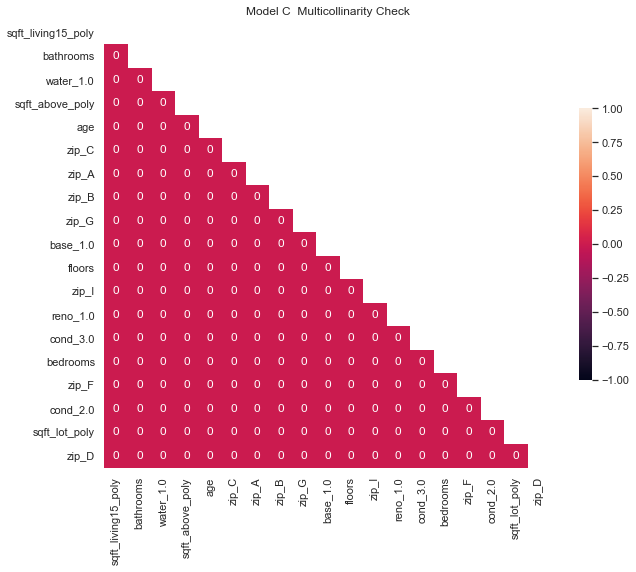

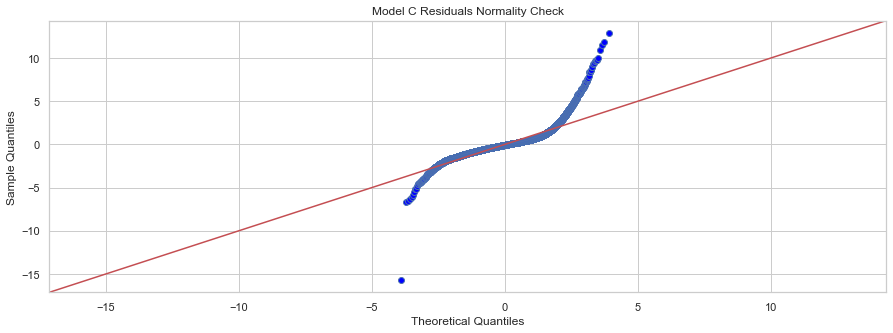

<Figure size 432x288 with 0 Axes>

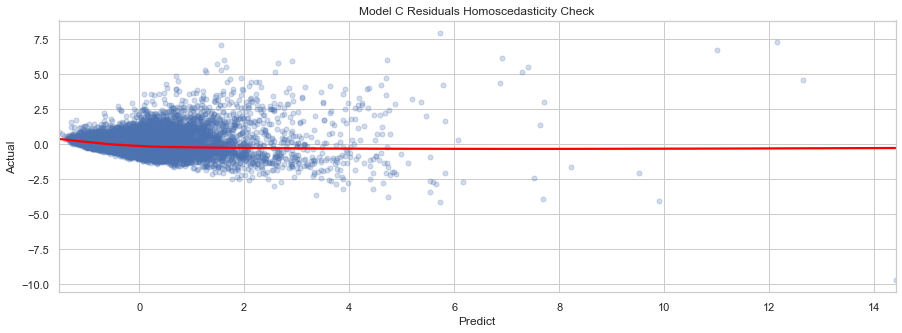

<Figure size 432x288 with 0 Axes>

In [370]:
#recheck for multicollinearity
mask = np.zeros_like(abs(X[result_C].corr()) > 0.75)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax = sns.heatmap(abs(X[result_C].corr()) > 0.75, 
                     annot = True, 
                     ax = ax, 
                     cbar_kws = {"shrink": .5}, 
                     mask = mask, 
                     vmax = 1,
                     vmin = -1,
                     square = True)
    plt.title('Model C  Multicollinarity Check')
plt.savefig('./Data & Figures/model_C_multicollinarity_check')

#recheck for normality
fig = sm.graphics.qqplot(model_C.resid, 
                         dist = stats.norm, 
                         line = '45', 
                         fit = True)
fig.set_size_inches(15, 5)
plt.title('Model C Residuals Normality Check')
plt.show()
plt.savefig('./Data & Figures/model_C_residuals_qqplot')

#recheck for homoscedasticity
plt.figure(figsize = (15, 5))
sns.regplot(x = model_C.predict(), 
            y = model_C.resid, 
            lowess = True, 
            line_kws = {'color': 'red'},
            scatter_kws = {'s': 25,'alpha':0.25})
plt.title('Model C Residuals Homoscedasticity Check')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()
plt.savefig('./Data & Figures/model_C_homoscedasticity_regplot')

In [371]:
#Goldfeld-Quandt test
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(model_C.resid, model_C.model.exog)
list(zip(name, test))

[('F statistic', 1.1492531751257562), ('p-value', 3.2749221992642826e-13)]

In [372]:
#split the data into training and test sets. Use the default split size
X_train, X_test, y_train, y_test = train_test_split(X[result_C], y, test_size = 0.2, random_state = 42)
print(len(X_train), len(y_train), len(X_test), len(y_test))

linreg = LinearRegression()

#fit the model to train data
linreg.fit(X_train, y_train)

#calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

#calculate residuals (prediction - actual error)
train_residual = y_hat_train - y_train
test_residual = y_hat_test - y_test

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)

print(train_mse)
print(test_mse)

17136 17136 4284 4284
0.37851109369912955
0.39039871032934814


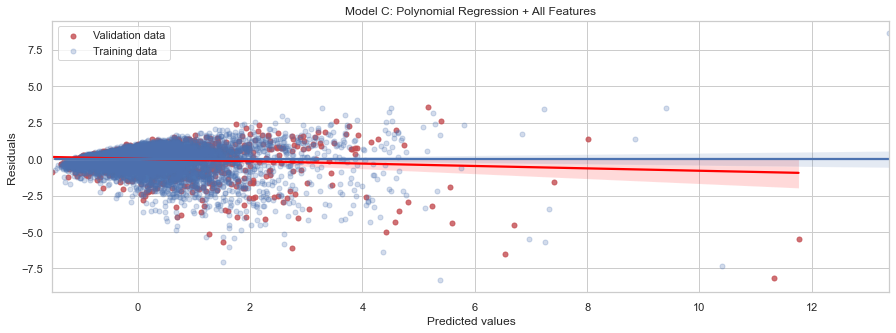

<Figure size 432x288 with 0 Axes>

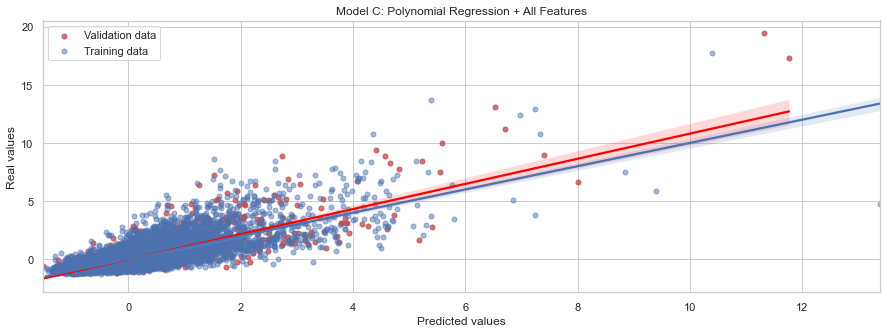

<Figure size 432x288 with 0 Axes>

In [373]:
#plot residuals: 
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_hat_test - y_test,
            scatter_kws = {'s': 25}, 
            line_kws = {'color': 'red'},
            color = 'r',
            fit_reg = True, label = 'Validation data')
sns.regplot(x = y_hat_train, y = y_hat_train - y_train,
            scatter_kws = {'s': 25,'alpha': 0.25}, 
            fit_reg = True, label = 'Training data')

plt.title('Model C: Polynomial Regression + All Features')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = "upper left")
plt.show()
plt.savefig('./Data & Figures/model_C_residuals_regplot')

#plot predictions
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_test, 
            line_kws = {'color': 'red'},
            scatter_kws = {'s': 25}, 
            color = 'r',
            fit_reg = True, label = 'Validation data')
sns.regplot(x = y_hat_train, y = y_train,  
                scatter_kws = {'s': 25,'alpha': 0.5}, fit_reg = True, label = 'Training data')

plt.title('Model C: Polynomial Regression + All Features')
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig('./Data & Figures/model_C_predictions_regplot')

In [374]:
#get accuracy percentage
accuracy = linreg.score(X_test, y_test)
"Accuracy: {}%".format(int(round(accuracy * 100)))

'Accuracy: 67%'

In [375]:
#cross-validation to check for overfitting
linreg = LinearRegression()

cv_result = cross_val_score(linreg, X[result_C], y, cv = 10, scoring = 'neg_mean_squared_error')
print(cv_result.mean())

-0.3864108608759037


In [376]:
#save model
tuple_objects = (linreg, X_train, y_train)
pickle.dump(tuple_objects, open('./Data & Figures/model_C.pkl','wb'))

In [377]:
summary_table_1.loc[2] = ['Model C', 'All features + Polynomial Regression', len(result_C), 
                          r2_score(y, yhat), round(accuracy * 100),
                         'P', 'F', 'F', 
                          cv_result.mean()]
summary_table_1.head()

,Model,Description,Num Features,r2,Accuracy,Multicollinearity,Normality,Homoscedasticity,Cross Validation
0,Model A,All features,19.0,0.668177,66.236718,P,F,F,-0.336769
1,Model B,"All features, outliers removed, RFE",13.0,0.645805,64.221137,P,F,F,-0.288712
2,Model C,All features + Polynomial Regression,19.0,0.619854,67.000000,P,F,F,-0.386411


# MODEL D
## MODEL REFINEMENT II: 
## LOG TRANSFORM NON-NORMAL CONTINUOUS FEATURES

In [378]:
preprocessed_log_D = clean[['price', 'sqft_above_log', 'sqft_lot_log', 'sqft_living15_log',
                            'age', 'bedrooms', 'bathrooms', 'floors',
                            'water_1.0', 'base_1.0', 'reno_1.0',
                            'cond_2.0', 'cond_3.0', 'cond_5.0',
                            'zip_A', 'zip_B', 'zip_C', 'zip_E', 'zip_D', 'zip_F', 'zip_G', 'zip_H', 'zip_I']]

In [379]:
#drop p-value > 0.05
#preprocessed_log_D.drop('bathrooms', axis = 1)

In [380]:
#drop p-value > 0.05
#preprocessed_log_D.drop('zip_C', axis = 1)

In [381]:
X = preprocessed_log_D.drop(['price'], axis=1)
y = preprocessed_log_D['price']

In [382]:
#apply stepwise function
result_D = stepwise_selection(X, y, verbose = True)
print('Resulting Features:')
print(result_D)

Add  bathrooms                      with p-value 0.0
Add  sqft_above_log                 with p-value 0.0
Add  water_1.0                      with p-value 0.0
Add  age                            with p-value 0.0
Add  sqft_living15_log              with p-value 2.47836e-282
Add  zip_A                          with p-value 0.0
Add  zip_C                          with p-value 0.0
Add  zip_B                          with p-value 2.80582e-179
Add  zip_G                          with p-value 8.83261e-98
Add  base_1.0                       with p-value 2.82616e-91
Add  bedrooms                       with p-value 1.67036e-81
Add  zip_E                          with p-value 1.74756e-17
Add  zip_I                          with p-value 4.51794e-18
Add  sqft_lot_log                   with p-value 3.50448e-13
Add  cond_5.0                       with p-value 5.36105e-09
Add  reno_1.0                       with p-value 5.54751e-07
Add  cond_3.0                       with p-value 1.33909e-05
Add  zip_

### Build Model D

In [383]:
#build model in statsmodels
#interecept is not included by default and should be added manually
X_in = X[result_D]
X_intercept = sm.add_constant(X_in) 

#estimation by ordinary least squares (OLS)
model_D = sm.OLS(y, X_intercept).fit() 

#get summary
model_D.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     1914.
Date:                Fri, 29 Jan 2021   Prob (F-statistic):               0.00
Time:                        14:44:06   Log-Likelihood:                -20119.
No. Observations:               21420   AIC:                         4.028e+04
Df Residuals:                   21401   BIC:                         4.043e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -12.5925      0.133    -94.483      0.000     -12.854     -12.331
bathrooms             0.3086      0.010     31.751      0.000       0.290       0.328
sqft_above_log        0.9722      0.021     46.933      0.000       0.932       1.013
water_1.0             2.4149      0.052     46.204      0.000       2.312       2.517
age                   0.1668      0.007     25.592      0.000       0.154       0.180
sqft_living15_log     0.5534      0.021     26.756      0.000       0.513       0.594
zip_A                 0.7798      0.016     50.207      0.000       0.749       0.810
zip_C                 0.8628      0.017     50.764      0.000       0.829       0.896
zip_B                 0.5115      0.016     31.516      0.000       0.480       0.543
zip_G                 0.3944      0.019     21.132      0.000       0.358       0.431
base_1.0              0.2608      0.011     23.264      0.000       0.239       0.283
bedrooms             -0.1131      0.006    -18.550      0.000      -0.125      -0.101
zip_E                 0.1717      0.021      8.348      0.000       0.131       0.212
zip_I                 0.2053      0.028      7.376      0.000       0.151       0.260
sqft_lot_log          0.0413      0.006      6.994      0.000       0.030       0.053
cond_5.0              0.0767      0.017      4.410      0.000       0.043       0.111
reno_1.0              0.1359      0.025      5.535      0.000       0.088       0.184
cond_3.0             -0.0476      0.011     -4.441      0.000      -0.069      -0.027
zip_F                -0.0756      0.019     -4.015      0.000      -0.113      -0.039
==============================================================================
Omnibus:                    20709.411   Durbin-Watson:                   1.317
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3010263.665
Skew:                           4.313   Prob(JB):                         0.00
Kurtosis:                      60.432   Cond. No.                         461.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [384]:
#create linear regression object
linreg = LinearRegression()

#fit model
linreg.fit(X[result_D], y)

#predict yhat using our model
yhat = linreg.predict(X[result_D])
yhat

array([-1.29316773, -0.97428318, -0.62661679, ..., -0.59519044,
       -0.30646373, -0.4144427 ])

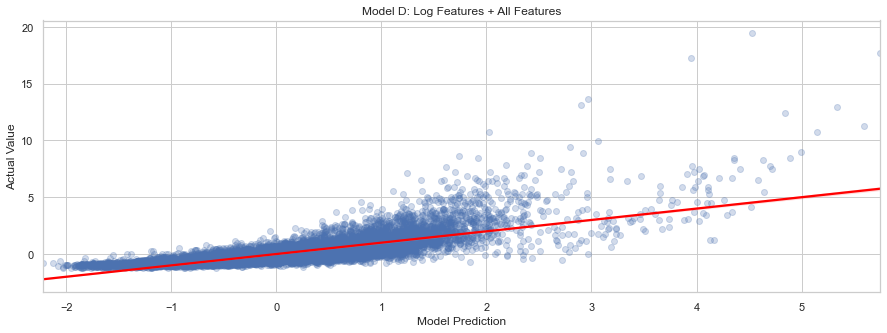

In [385]:
#plot y_hat
plt.figure(figsize = (15, 5))
sns.regplot(yhat, y, 
            line_kws = {'color': 'red'},
            scatter_kws = {'color':'b','alpha': 0.25},color='r')
plt.title('Model D: Log Features + All Features')
plt.xlabel('Model Prediction')
plt.ylabel('Actual Value');
plt.savefig('./Data & Figures/model_2_scatterplot')

In [386]:
#get intercept
linreg.intercept_

-12.592525686898604

### Test Model D

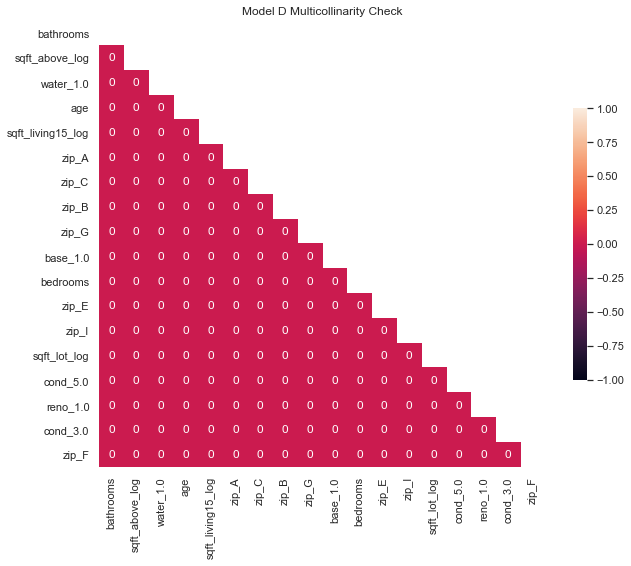

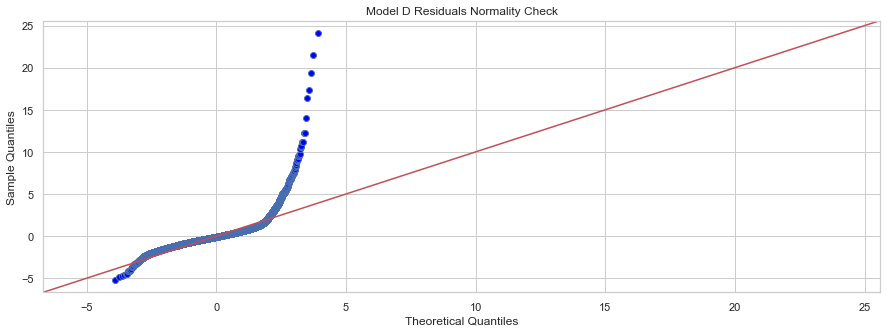

<Figure size 432x288 with 0 Axes>

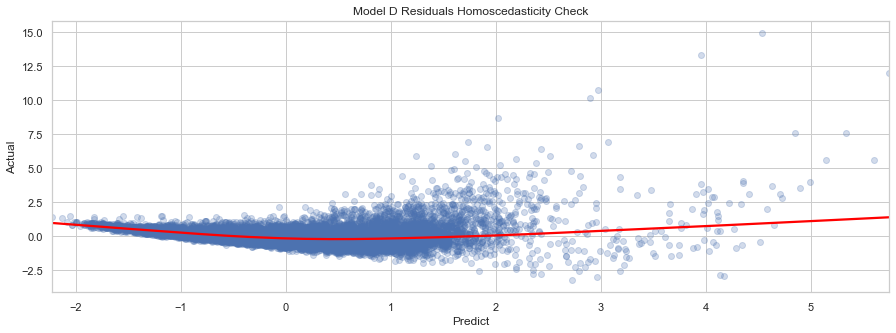

<Figure size 432x288 with 0 Axes>

In [387]:
#recheck for multicollinearity
mask = np.zeros_like(abs(X[result_D].corr()) > 0.75)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax = sns.heatmap(abs(X[result_D].corr()) > 0.75, 
                     annot = True, 
                     ax = ax, 
                     cbar_kws = {"shrink": .5}, 
                     mask = mask, 
                     vmax = 1,
                     vmin = -1,
                     square = True)
    plt.title('Model D Multicollinarity Check')
plt.savefig('./Data & Figures/model_D_multicollinarity_check')

#recheck for normality
fig = sm.graphics.qqplot(model_D.resid, 
                         dist = stats.norm, 
                         line = '45', 
                         fit = True)
fig.set_size_inches(15, 5)
plt.title('Model D Residuals Normality Check')
plt.show()
plt.savefig('./Data & Figures/model_D_residuals_qqplot')

#recheck for homoscedasticity
plt.figure(figsize = (15, 5))
sns.regplot(x = model_D.predict(), 
            y = model_D.resid, 
            lowess = True, 
            line_kws = {'color': 'red'},
            scatter_kws = {'color':'b','alpha': 0.25}, color = 'r')
plt.title('Model D Residuals Homoscedasticity Check')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()
plt.savefig('./Data & Figures/model_D_homoscedasticity_regplot')

In [388]:
#Goldfeld-Quandt test
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(model_D.resid, model_D.model.exog)
list(zip(name, test))

[('F statistic', 1.0033659956380807), ('p-value', 0.43104232776730933)]

In [389]:
#split the data into training and test sets. Use the default split size
X_train, X_test, y_train, y_test = train_test_split(X[result_D], y, test_size = 0.20, random_state = 42)
print(len(X_train), len(y_train), len(X_test), len(y_test))

linreg = LinearRegression()

#fit the model to train data
linreg.fit(X_train, y_train)

#calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

#calculate residuals
train_residual = y_hat_train - y_train
test_residual = y_hat_test - y_test

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)

print(train_mse)
print(test_mse)

17136 17136 4284 4284
0.3599981676619762
0.47776670696778284


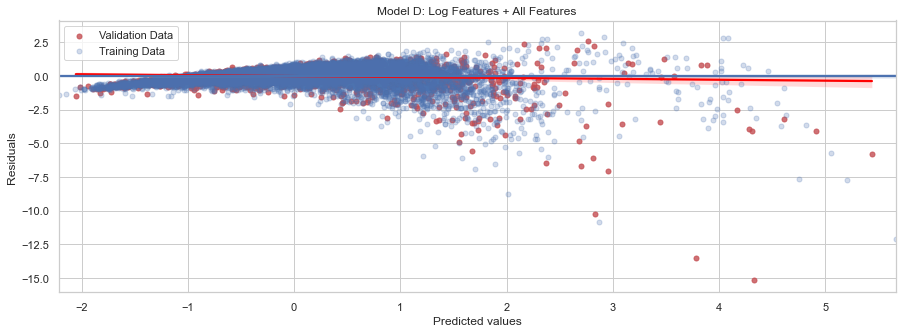

<Figure size 432x288 with 0 Axes>

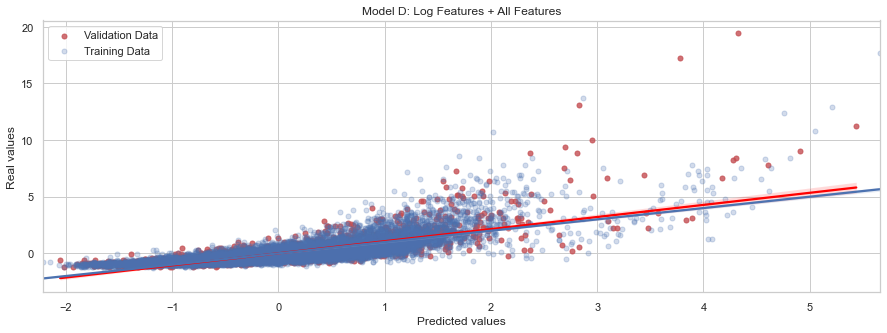

<Figure size 432x288 with 0 Axes>

In [390]:
#plot residuals: 
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_hat_test - y_test,
            scatter_kws = {'s': 25}, 
            line_kws = {'color': 'red'},
            color = 'r',
            fit_reg = True, label = 'Validation Data')
sns.regplot(x = y_hat_train, y = y_hat_train - y_train,
            scatter_kws = {'s': 25,'alpha': 0.25}, 
            fit_reg = True, label = 'Training Data')


plt.title('Model D: Log Features + All Features')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig('./Data & Figures/model_D_residuals_regplot')

#plot predictions
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_test,
            scatter_kws = {'s': 25}, 
            line_kws = {'color': 'red'}, 
            color = 'r',
            fit_reg = True, label = 'Validation Data')
sns.regplot(x = y_hat_train, y = y_train,
            scatter_kws = {'s': 25,'alpha':0.25}, 
            fit_reg = True, label = 'Training Data')

plt.title('Model D: Log Features + All Features')
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig('./Data & Figures/model_D_predictions_regplot')

In [391]:
#get accuracy percentage
accuracy = linreg.score(X_test, y_test)
"Accuracy: {}%".format(int(round(accuracy * 100)))

'Accuracy: 59%'

In [392]:
#cross-validation to check for overfitting
linreg = LinearRegression()

#get the mean squared error
mse = make_scorer(mean_squared_error)

cv_result = cross_val_score(linreg, X[result_D], y, cv = 10, scoring = 'neg_mean_squared_error')
print(cv_result.mean())

-0.38726082584390137


In [393]:
#save model
tuple_objects = (linreg, X_train, y_train)
pickle.dump(tuple_objects, open('./Data & Figures/model_D.pkl','wb'))

In [394]:
#update summary
summary_table_1.loc[3] = ['Model D', 'All features + Log', len(result_D), 
                          r2_score(y, yhat), accuracy * 100,
                         'P', 'F', 'F',
                         cv_result.mean()]
summary_table_1.head()

,Model,Description,Num Features,r2,Accuracy,Multicollinearity,Normality,Homoscedasticity,Cross Validation
0,Model A,All features,19.0,0.668177,66.236718,P,F,F,-0.336769
1,Model B,"All features, outliers removed, RFE",13.0,0.645805,64.221137,P,F,F,-0.288712
2,Model C,All features + Polynomial Regression,19.0,0.619854,67.000000,P,F,F,-0.386411
3,Model D,All features + Log,18.0,0.616832,59.185618,P,F,F,-0.387261


In [395]:
#save
summary_table_1.to_csv('./Data & Figures/summary_table_1')